In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import matplotlib.pyplot as plt
import math
from mode_conn import train_bezier_bends, compute_mode_connectivity, bezier_curve, compute_loss
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

cuda
Train size: 132, Holdout size: 132, Test size: 136


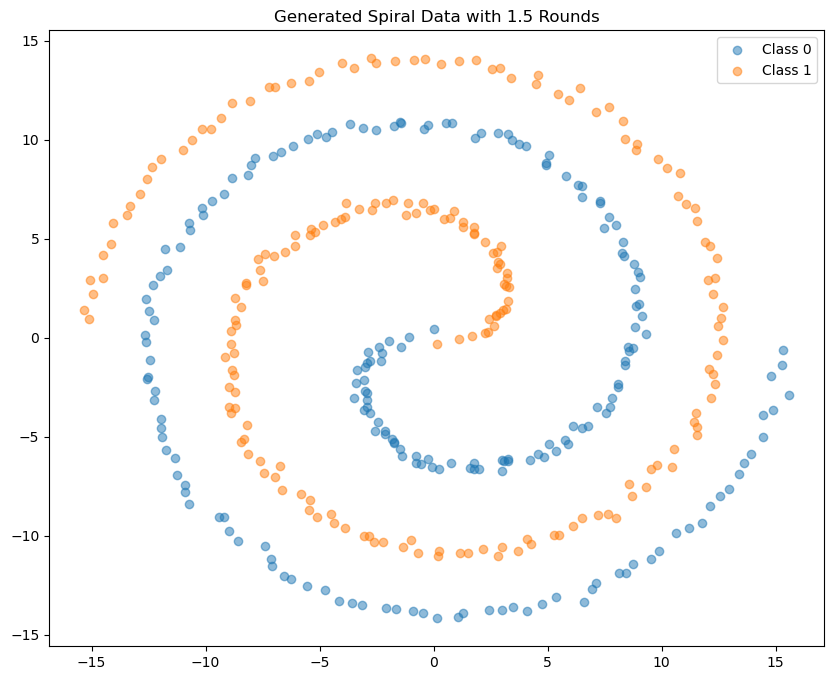

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device('cpu')
print(device)


def generate_spiral_data(n_points = 1000, n_cycles = 5, noise_std_dev = 0.1):
    red_noise = np.random.normal(0, noise_std_dev, [2, n_points])
    blue_noise = np.random.normal(0, noise_std_dev, [2, n_points])

    # Generate Data
    theta_max = n_cycles * (2 * math.pi)
    step_size = theta_max / n_points

    red_data = [[5 * math.sqrt(t * step_size) * math.cos(t * step_size) + red_noise[0][t],
                 5 * math.sqrt(t * step_size) * math.sin(t * step_size) + red_noise[1][t]]
                for t in range(n_points)]

    blue_data = [[-5 * math.sqrt(t * step_size) * math.cos(t * step_size) + blue_noise[0][t],
                  -5 * math.sqrt(t * step_size) * math.sin(t * step_size) + blue_noise[1][t]]
                 for t in range(n_points)]

    data = np.array(red_data + blue_data)
    labels = np.array([1] * n_points + [0] * n_points)

    return list(zip(data, labels))

# Generate data
n_points = 200
n_cycles = 1.5
noise = 0.2
spiral_data = generate_spiral_data(n_points = n_points, n_cycles=n_cycles, noise_std_dev=noise)
random.shuffle(spiral_data)

# Split the data
train_ratio = 0.33
holdout_ratio = 0.33
test_ratio = 1- train_ratio - holdout_ratio

train_size = int(2*n_points * train_ratio)
holdout_size = int(2*n_points * holdout_ratio)
test_size = 2*n_points - train_size - holdout_size

print(f"Train size: {train_size}, Holdout size: {holdout_size}, Test size: {test_size}")

train_data = spiral_data[:train_size]
holdout_data = spiral_data[train_size:train_size + holdout_size]
swapped_holdout_data = [(data, 1 - label) for data, label in holdout_data]
test_data = spiral_data[train_size + holdout_size:train_size + holdout_size + test_size]

# Plot the generated spiral data
data, labels = zip(*spiral_data)
data = np.array(data)
labels = np.array(labels)

plt.figure(figsize=(10, 8))
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], label='Class 0', alpha=0.5)
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], label='Class 1', alpha=0.5)
plt.title(f'Generated Spiral Data with {n_cycles} Rounds')
plt.legend()
plt.show()


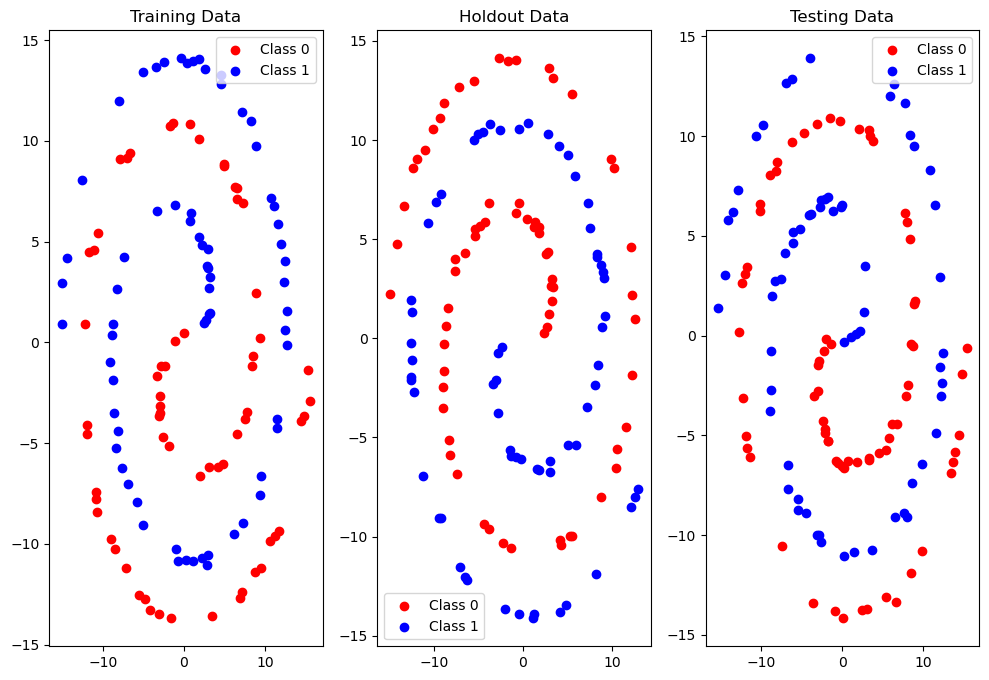

In [4]:


# Separate coordinates and labels for plotting
train_coords, train_labels = zip(*train_data)
holdout_coords, holdout_labels = zip(*swapped_holdout_data)
test_coords, test_labels = zip(*test_data)

train_coords = np.array(train_coords)
train_labels = np.array(train_labels)
holdout_coords = np.array(holdout_coords)
holdout_labels = np.array(holdout_labels)
test_coords = np.array(test_coords)
test_labels = np.array(test_labels)

# Plot the data
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.scatter(train_coords[train_labels == 0][:, 0], train_coords[train_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(train_coords[train_labels == 1][:, 0], train_coords[train_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Training Data')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(holdout_coords[holdout_labels == 0][:, 0], holdout_coords[holdout_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(holdout_coords[holdout_labels == 1][:, 0], holdout_coords[holdout_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Holdout Data')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(test_coords[test_labels == 0][:, 0], test_coords[test_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(test_coords[test_labels == 1][:, 0], test_coords[test_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Testing Data')
plt.legend()

plt.show()


In [5]:
class SpiralDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coords, label = self.data[idx]
        return torch.tensor(coords).float(), torch.tensor(label).float().view(1)
untraining_data = train_data + swapped_holdout_data
random.shuffle(untraining_data)
untraining_coords, untraining_labels = zip(*untraining_data)
untraining_coords = np.array(untraining_coords)
untraining_labels = np.array(untraining_labels)
# Move data to device
train_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in train_data]
holdout_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in swapped_holdout_data]
test_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in test_data]
untraining_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in untraining_data]

train_dataset = SpiralDataset(train_data)
holdout_dataset = SpiralDataset(swapped_holdout_data)
test_dataset = SpiralDataset(test_data)
untraining_dataset = SpiralDataset(untraining_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
untraining_loader = DataLoader(untraining_dataset, batch_size=64, shuffle=True)


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 25)
        self.fc4 = nn.Linear(25, 25)
        self.fc5 = nn.Linear(25, 25)
        self.fc6 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [7]:
"""If models are already trained, load them"""
model1 = Net().to(device)
model2 = Net().to(device)
model1.load_state_dict(torch.load(os.path.join("saved_models", "model1.pth"), weights_only=False))
model2.load_state_dict(torch.load(os.path.join("saved_models", "model2.pth"), weights_only=False))
criterion = nn.BCEWithLogitsLoss()


"""
To train the models in case they are not saved
"""
# # Starting from two random initializations of the same model
# model1 = Net().to(device)
# model2 = Net().to(device)

# # Train the models
# criterion = nn.BCEWithLogitsLoss()
# optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
# optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# n_epochs = 1000

# for epoch in range(n_epochs):
#     model1.train()
#     model2.train()
#     for inputs, labels in train_loader:
#         optimizer1.zero_grad()
#         optimizer2.zero_grad()

#         outputs1 = model1(inputs)
#         outputs2 = model2(inputs)

#         loss1 = criterion(outputs1, labels)
#         loss2 = criterion(outputs2, labels)

#         loss1.backward()
#         loss2.backward()

#         optimizer1.step()
#         optimizer2.step()

model1.eval()
model2.eval()

test_loss1 = 0
test_loss2 = 0

correct1 = 0
correct2 = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)

        labels.view(-1, 1)

        test_loss1 += criterion(outputs1, labels).item()
        test_loss2 += criterion(outputs2, labels).item()

        pred1 = (outputs1 > 0).float()
        pred2 = (outputs2 > 0).float()

        correct1 += (pred1 == labels.byte()).float().sum().item()
        correct2 += (pred2 == labels.byte()).float().sum().item()

test_loss1 /= len(test_loader.dataset)
test_loss2 /= len(test_loader.dataset)

accuracy1 = correct1 / len(test_loader.dataset)
accuracy2 = correct2 / len(test_loader.dataset)

print(f"Model 1 Test Loss: {test_loss1}, Model 1 Test Accuracy: {accuracy1}")
print(f"Model 2 Test Loss: {test_loss2}, Model 2 Test Accuracy: {accuracy2}")


/tmp/ipykernel_228424/1264919551.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(coords).float(), torch.tensor(label).float().view(1)


Model 1 Test Loss: 0.009804297895992504, Model 1 Test Accuracy: 0.9485294117647058
Model 2 Test Loss: 0.016892965663881862, Model 2 Test Accuracy: 0.8823529411764706


In [8]:

train_coords = torch.tensor(train_coords).float().to(device)
train_labels = torch.tensor(train_labels).float().view(-1,1).to(device)
holdout_coords = torch.tensor(holdout_coords).float().to(device)
holdout_labels = torch.tensor(holdout_labels).float().view(-1,1).to(device)
test_coords = torch.tensor(test_coords).float().to(device)
test_labels = torch.tensor(test_labels).float().view(-1,1).to(device)

# Computing the mode connectivity between the two minima

In [9]:
%%time
min1 = [p.clone().detach() for p in model1.parameters()]
min2 = [p.clone().detach() for p in model2.parameters()]

model = Net().to(device)
k = 1
bends = train_bezier_bends(model, min1, min2, k, train_loader, device, lr = 0.001 , steps = 1000)

mc_score = compute_mode_connectivity(model, min1, min2, bends, train_loader, device)
print(f"Mode Connectivity Score: {mc_score}")

TypeError: optimizer can only optimize Tensors, but one of the params is torch.nn.modules.container.ParameterList

In [ ]:
def flatten_weights(weights):
    """Flattens model weights into a single 1D vector."""
    return torch.cat([w.view(-1) for w in weights]).detach().cpu().numpy()

In [ ]:
def get_bezier_path(model, theta1, theta2, bends, train_loader, device, num_points=50):
    """Samples weights along the Bézier curve and computes loss at each step."""
    weights_list = []
    loss_values = []
    t_values = np.linspace(0, 1, num_points)

    for t in t_values:
        weights = bezier_curve(torch.tensor(t, device=theta1[0].device), theta1, theta2, bends)
        weights_list.append(flatten_weights(weights))

        # Compute loss at this point on the Bézier curve
        loss = compute_loss(model, weights, train_loader, device)
        loss_values.append(loss)

    return np.array(weights_list), np.array(loss_values)  # Returns high-dim weight vectors & loss values

In [ ]:
def plot_bezier_curve(model, theta1, theta2, bends, train_loader, device, method='pca'):
    """Plots the Bézier curve using PCA or t-SNE with loss-based coloring and loss vs t graph."""
    weights_array, loss_values = get_bezier_path(model, theta1, theta2, bends, train_loader, device, num_points=50)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=3, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    # Combine weights and control points for consistent transformation
    control_points = [theta1] + bends + [theta2]
    flattened_control_points = [torch.cat([p.view(-1) for p in point]).detach().cpu().numpy() for point in control_points]
    combined_points = np.vstack([weights_array] + flattened_control_points)

    # Fit and transform the combined points
    reduced_combined_points = reducer.fit_transform(combined_points)

    # Separate the transformed weights and control points
    reduced_weights = reduced_combined_points[:len(weights_array)]
    reduced_control_points = reduced_combined_points[len(weights_array):]

    # Plot the curve with loss-based coloring
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(reduced_weights[:, 0], reduced_weights[:, 1], c=loss_values, cmap='coolwarm', label="Bézier Path", alpha=0.8)
    plt.colorbar(scatter, label="Loss Value")  # Color bar represents loss

    # Mark the minima
    plt.scatter(reduced_weights[0, 0], reduced_weights[0, 1], color='red', marker='o', s=100, label="Min 1")
    plt.scatter(reduced_weights[-1, 0], reduced_weights[-1, 1], color='blue', marker='o', s=100, label="Min 2")

    # Mark the control points
    plt.scatter(reduced_control_points[:, 0], reduced_control_points[:, 1], color='green', marker='x', s=100, label="Control Points")
    
    plt.title(f"Bézier Curve Visualization with Loss Coloring using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()

    # Plot the loss vs t graph
    plt.subplot(1, 2, 2)
    t_values = torch.linspace(0, 1, len(loss_values))
    plt.plot(t_values, loss_values, marker='o', linestyle='-', color='purple')
    plt.title("Loss vs t")
    plt.xlabel("t")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_bezier_curve(model, min1, min2, bends, train_loader, device, method='pca')
plot_bezier_curve(model, min1, min2, bends, train_loader, device, method='tsne')

NameError: name 'bends' is not defined